# Comparison of track parameter in full and fast simulation

I want to plot the 5 track parameters and the 15 covariance parameters for $H \rightarrow u \bar{u}$ for the leading tracks in fast and full simulation. Therefore, I need to make sure to plot the same track params and especially find out what the 15 covariance parameters mean.

In [47]:
save=False

In [1]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator, FuncFormatter

import gc

from sklearn.metrics import roc_curve, auc, roc_auc_score
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm

%load_ext autoreload
%autoreload 2

In [2]:
from scipy.optimize import curve_fit

In [3]:
from cycler import cycler
import matplotlib

# Set the color cycle
# https://coolors.co/542344-f68e5f-e5e059-007ea7-98e2c6
plt.rc('axes', prop_cycle=cycler('color', ['#73b06f', '#e6701b', '#007090', '#e7298a', '#802392', '#ffad08', '#56b4e9']))
matplotlib.rcParams["font.family"] = "serif"
# Set font sizes
matplotlib.rcParams.update(
    {
        "font.size": 14,  # General font size
    }
)

In [4]:
path_fullsim = "/eos/experiment/fcc/ee/datasets/CLD_fullsim_tagging_debug_tracks/Huu.root"
path_fastsim = "/eos/experiment/fcc/ee/jet_flavour_tagging/winter2023/samples_v7/CLD_Huu_debug_tracks/Huu.root"

In [5]:
def load_data(file_name, stop=250000):
    file = uproot.open(file_name)
    tree = file['tree;1']
    data = tree.arrays(library="np", entry_start=0, entry_stop=stop)
    return data

In [6]:
dic = {"fast": load_data(path_fastsim), "full": load_data(path_fullsim),}

In [7]:
dic["fast"].keys()

dict_keys(['recojet_isG', 'recojet_isS', 'recojet_isC', 'recojet_isB', 'recojet_isTAU', 'recojet_isU', 'recojet_isD', 'jet_p', 'jet_e', 'jet_mass', 'jet_phi', 'jet_theta', 'jet_nconst', 'jet_nmu', 'jet_nel', 'jet_nchad', 'jet_ngamma', 'jet_nnhad', 'jet_npfcand', 'pfcand_erel_log', 'pfcand_thetarel', 'pfcand_phirel', 'pfcand_dptdpt', 'pfcand_detadeta', 'pfcand_dphidphi', 'pfcand_dxydxy', 'pfcand_dzdz', 'pfcand_dxydz', 'pfcand_dphidxy', 'pfcand_dlambdadz', 'pfcand_dxyc', 'pfcand_dxyctgtheta', 'pfcand_phic', 'pfcand_phidz', 'pfcand_phictgtheta', 'pfcand_cdz', 'pfcand_cctgtheta', 'pfcand_mtof', 'pfcand_dndx', 'pfcand_charge', 'pfcand_isMu', 'pfcand_isEl', 'pfcand_isChargedHad', 'pfcand_isGamma', 'pfcand_isNeutralHad', 'pfcand_type', 'pfcand_dxy', 'pfcand_dz', 'pfcand_C', 'pfcand_ct', 'pfcand_omega', 'pfcand_btagSip2dVal', 'pfcand_btagSip2dSig', 'pfcand_btagSip3dVal', 'pfcand_btagSip3dSig', 'pfcand_btagJetDistVal', 'pfcand_btagJetDistSig', 'pfcand_e', 'pfcand_p', 'pfcand_theta', 'pfcand_phi

First, let's get the leading tracks.

In [8]:
def get_index_charged_particles(df, ptype='cpart'):
    """Choose particle type: cpart, npart, photon"""
    if df == 'fast':
        types = dic[df]['pfcand_type']
        if ptype=='cpart':
            num = [0]
        elif ptype=='npart':
            num = [130]
        elif ptype=='photon':
            num = [22]
    elif df == 'full':
        types = dic[df]['pfcand_type']
        if ptype=='cpart':
            num = [-211, -13, -11, 11, 13, 211] 
        elif ptype=='npart':
            num = [2112]
        elif ptype=='photon':
            num = [22]
    mask_bool_chad = []
    for i in range(types.shape[0]):
        index = np.where(np.isin(types[i], num))[0]
        bool_list = np.zeros(len(types[i]), dtype=bool)
        bool_list[index] = True
        mask_bool_chad.append(bool_list)
    return mask_bool_chad

In [9]:
def get_value_highest_energy_particle(df, k=3, ptype='cpart', debug=False):
    """return the index of the k highest energy charged particle in each event"""
    if df == 'fast':
        particles_e = dic[df]['pfcand_e']
        mask_chad = get_index_charged_particles('fast', ptype=ptype)
    elif df == 'full':
        particles_e = dic[df]['pfcand_e']
        mask_chad = get_index_charged_particles('full', ptype=ptype)
    index_charged = []
    for i  in range(particles_e.shape[0]):
        part_e = particles_e[i]
        ind = np.argsort(part_e)[::-1]
        mask = mask_chad[i]
        c_index = np.arange(len(part_e))[mask] # indicies with charged/neutral particles
        # now order the charged/neutral particles by energy with ind
        index_map = {value: np.where(ind == value)[0][0] for value in c_index}
        sorted_c_index = sorted(c_index, key=lambda x: index_map[x])
        index_charged.append(sorted_c_index[:k])
        if debug and i==1:
            print("part_e: ", part_e)
            print("mask: ", mask)
            print("ind: ", ind)
            print("index_map: ", index_map)
            print("c_index: ", c_index)
            print("sorted_c_index: ", sorted_c_index)
    return index_charged

In [10]:
def get_chad_elements(df_value, index):
    e_1 = []
    e_2 = []
    e_3 = []
    for i in range(len(df_value)):
        index_list = index[i] # this can have 1, 2 or 3 elements
        if len(index_list) == 1:
            e_1.append(df_value[i][index_list[0]])
        elif len(index_list) == 2:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
        elif len(index_list) == 3:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
            e_3.append(df_value[i][index_list[2]])
    return [np.array(e_1), np.array(e_2), np.array(e_3)]

In [11]:
index_charged_3E_full = get_value_highest_energy_particle("full")
index_charged_3E_fast = get_value_highest_energy_particle("fast")

Now we can get any variable `key` with `myvar = get_chad_elements(dic["fast"][key], index_charged_3E_fast)`. 

## Helix track parameters

I want to use the full sim convension and use $\vec \alpha = (d_0, \phi, c, z_0, \tan \lambda)$ to describe a helix track. Let's see how we can retrieve these variables. 
- $d_0$: that's `pfcand_dxy`
- $\phi$: that's `pfcand_phi`
- $c$: well, that should be $c = \frac{a}{2 \cdot p_t}$ with $a = -q \cdot B_z \cdot v_\mathrm{light}$. We can get $p_t = \sin{\theta} \cdot |p|$. So all in all, it's $c = \frac{-q \cdot B_z \cdot v_\mathrm{light}}{2 \cdot \sin{\theta} \cdot |p|}$ It has units of 1/s.
- $z_0$: that's `pfcand_dz`
- $\tan \lambda$: This is $\tan \lambda = \frac{p_z}{p_t} = \frac{\cos{\theta} \cdot |p|}{\sin{\theta} \cdot |p|} = \cot{\theta}$. We use `pfcand_theta` and calculate $\cot{\theta} = 1/ \tan{\theta}$. If we save $\cot{\theta}$ used in the analysis, the distributions match, that's great. 

**Not plotting anymore but checked:**
- $\tan{\lambda} = \cot{\theta}$ (using 1/tangent of `pfcand_theta` and `pfcand_ct`)


**$\omega$ vs $c$**:

- What I have called $c$ so far is actually in the units of 1/s and therefore a frequency and not a curvature. 
- What they call $\omega$ is in 1/mm and therefore _not_ a frequency but acutally the curvature. 

Let's check if that's consistent? If I multiply $\omega$ by the speed of light I should get $c$?

In [12]:
def get_5_track_params(data, index_charged):
    """ Get the 5 track parameters for the highest energy charged particle"""
    d0 = get_chad_elements(data['pfcand_dxy'], index_charged)[0]
    z0 = get_chad_elements(data['pfcand_dz'], index_charged)[0]
    phi = get_chad_elements(data['pfcand_phi'], index_charged)[0]
    theta = get_chad_elements(data['pfcand_theta'], index_charged)[0]
    q = get_chad_elements(data['pfcand_charge'], index_charged)[0]
    p = get_chad_elements(data['pfcand_p'], index_charged)[0]
    omega = get_chad_elements(data['pfcand_omega'], index_charged)[0]
    curv = get_chad_elements(data['pfcand_C'], index_charged)[0]

    Bz = 2.0
    #c_light = 2.99792458e8 * 1.0e-9 # from fast sim ... https://github.com/HEP-FCC/FCCAnalyses/blob/63d346103159c4fc88cdee7884e09b3966cfeca4/analyzers/dataframe/src/ReconstructedParticle2Track.cc#L113 
    c_light = 2.99792458e8 * 1.0e-9 *10**(-3)

    # calculate the curvature
    # c = - q * Bz * c_light / (2 * np.sin(theta) * p) # OLD definition
    c = q * Bz * c_light / (np.sin(theta) * p)
    tanlam = 1 / np.tan(theta)

    return d0, phi, c, z0, tanlam, omega, curv


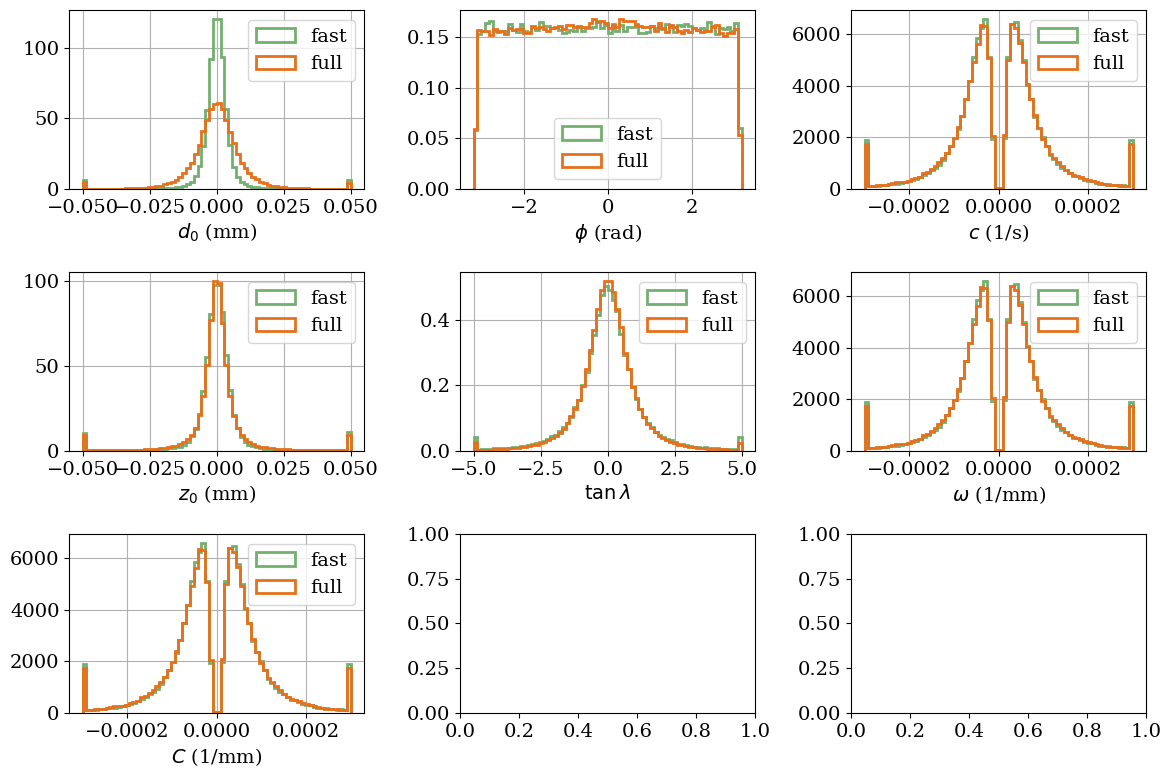

In [13]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8))
labels = [r"$d_0$ (mm)", r"$\phi$ (rad)", "$c$ (1/s)", "$z_0$ (mm)", r"$\tan{\lambda}$", r"$\omega$ (1/mm)", r"$C$ (1/mm)", r"$cot \theta$ (rad)"]
ranges = [(-0.05, 0.05), (-3.2, 3.2), (-3e-4, 3e-4), (-0.05, 0.05), (-5.0, 5.0), (-3e-4, 3e-4), (-0.3e-3, 0.3e-3)] # (-4.5e-4, 4.5e-4) c old (-0.1, 0.1), curv old (-0.3, 0.3)
bins = 70
for k in dic.keys():
    if k == "full":
        d0, phi, c, z0, tanlam, omega, curv = get_5_track_params(dic[k], index_charged_3E_full)
        curv = curv *10**(-3) * (-1) # so I do the same as in fast sim 
    elif k == "fast":
        d0, phi, c, z0, tanlam, omega, curv = get_5_track_params(dic[k], index_charged_3E_fast)
    else:
        raise ValueError("Wrong key") 

    curv = curv *2

    # overflow and underflow bins
    d0 = np.clip(d0, ranges[0][0], ranges[0][1])
    c = np.clip(c, ranges[2][0], ranges[2][1])
    z0 = np.clip(z0, ranges[3][0], ranges[3][1])
    tanlam = np.clip(tanlam, ranges[4][0], ranges[4][1])
    omega = np.clip(omega, ranges[5][0], ranges[5][1])
    curv = np.clip(curv, ranges[6][0], ranges[6][1])


    # plot the 5 track parameters
    axs = axs.ravel()
    for i, ax in enumerate(axs):
        # plot the histograms
        if i == 8 or i == 7:
            continue
        ax.hist([d0, phi, c, z0, tanlam, omega, curv][i], bins=bins, histtype='step', label=k, density=True, linewidth=2.0, range=ranges[i])
        ax.set_xlabel(labels[i])
        ax.legend()
        ax.grid(True)
plt.tight_layout()
#plt.savefig("plots/Huu_5track_params.pdf")
plt.show()


Ok, quick overview of this curvature thing:

They are all the same now, I did _not_ modfiy omega which is claimed to be in [1/mm].
- $c$: calculated by me by hand as 
    ```
    c_light = 2.99792458e8 * 1.0e-9 *10**(-3) # what units??
    c = q * Bz * c_light / (np.sin(theta) * p)
    ```
- $\omega$: from `TrackState.omega`, important bc used from cov matrix. I did _not_ modify this.
- $C$: saved as `pfcand_C` from script where it is calculated like I thought I would do for $c$...
    ```
    cSpeed = 2.99792458e8 * 1.0e-9 *10**(-3) # the last part is only in fastsim, I did not do this in full sim ...
    a = - particle_q * Bz * cSpeed
    C = a/ (2 * pt)
    ```

    and by hand I did $C = 2 \cdot C$

    this means $C = -c$ although in the histograms it's $C=c$. Ok, solved this too! The signs are the same in fast sim but in full sim I had the minus, in fast sim there wasn't. So it all makes sense!

------------- !!! ---------------

Ok, so to **summerize**: 

- $\omega$ from trackStates, I did not modify anything
- $c = C$! And it is $\omega = c = C = \frac{q \cdot B_z \cdot c_\mathrm{light}} {\sin(\theta) \cdot p} = \frac{q \cdot B_z \cdot c_\mathrm{light}} {p_t}$  with $c = 2.99792458e8 \cdot 10^{-12}$ in (1/mm). 

It's in 1/mm because $[\frac{q \cdot B_z \cdot c_\mathrm{light}} {p_t}] = \frac{\mathrm{As} \cdot \frac{\mathrm{kg}}{\mathrm{A}\mathrm{s}^2} \frac{\mathrm{m}}{\mathrm{s}}}{10^{-9} \cdot \frac{\mathrm{kg}\cdot \mathrm{m}^2}{\mathrm{s}^2}} \cdot 10^{-3} \cdot 10^{-9} = \frac{1}{\mathrm{mm}}$ when considering the units of $c$ and taking $p$ in GeV. 

------------- !!! ---------------

Ok let's have a closer look at $C$.

**fullsim**: 

`c = a/ (2 * pt)` with \
`pt = np.sqrt(particle_p.x**2 + particle_p.y **2)` \
`a = - particle_q * Bz * cSpeed` with `cSpeed = 2.99792458e8 * 1.0e-9` and `Bz=2`

**fastsim**:
From [here](https://github.com/HEP-FCC/FCCAnalyses/blob/pre-edm4hep1/addons/ONNXRuntime/python/jetFlavourHelper.py#L103) to [here](https://github.com/HEP-FCC/FCCAnalyses/blob/pre-edm4hep1/analyzers/dataframe/src/JetConstituentsUtils.cc#L255-L258) to [here](https://github.com/HEP-FCC/FCCAnalyses/blob/pre-edm4hep1/analyzers/dataframe/src/ReconstructedParticle2Track.cc#L194-L217). 

Finding

`const double cSpeed = 2.99792458e8 * 1.0e3 * 1.0e-15;` \
`double C = a/(2 * pt);`

so the difference lies in the units of the speed of light ... 

If I multiply $C$ from fast sim with $10^{3}$, then it should be the same? **YES**

Having a look at the curvature $C$ we find out that full and fast sim are equal apart from a factor $10^3$ that occurs throught the different definition of the speed of light (its units).

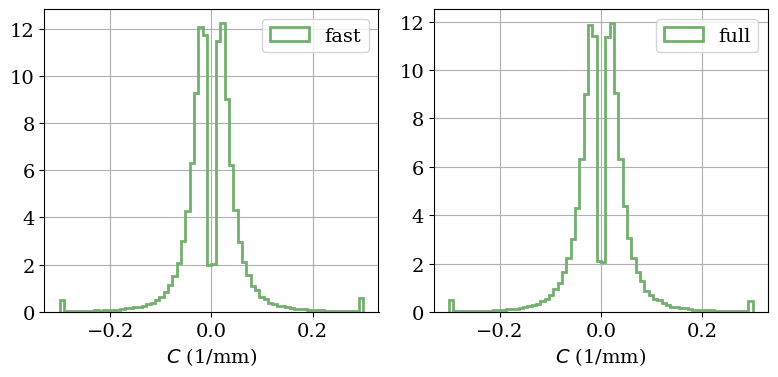

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
labels = [r"$d_0$ (mm)", r"$\phi$ (rad)", "$c$ (1/s)", "$z_0$ (mm)", r"$\tan{\lambda}$", r"$\omega$ (1/mm)", r"$C$ (1/mm)", r"$cot \theta$ (rad)"]
ranges = [(-0.05, 0.05), (-3.2, 3.2), (-0.1, 0.1), (-0.05, 0.05), (-5.0, 5.0), (-3e-4, 3e-4), (-0.01, 0.01), (-5.0, 5.0)] # (-4.5e-4, 4.5e-4)
r_curv = {"fast": (-0.3, 0.3), "full": (-0.3, 0.3)}# (-3e-4, 3e-4)
bins = 70
for i, k in enumerate(dic.keys()):
    if k == "full":
        d0, phi, c, z0, tanlam, omega, curv = get_5_track_params(dic[k], index_charged_3E_full)
    elif k == "fast":
        d0, phi, c, z0, tanlam, omega, curv = get_5_track_params(dic[k], index_charged_3E_fast)
        curv = curv *10**(3)
    else:
        raise ValueError("Wrong key") 

    # overflow and underflow bins
    d0 = np.clip(d0, ranges[0][0], ranges[0][1])
    c = np.clip(c, ranges[2][0], ranges[2][1])
    z0 = np.clip(z0, ranges[3][0], ranges[3][1])
    tanlam = np.clip(tanlam, ranges[4][0], ranges[4][1])
    omega = np.clip(omega, ranges[5][0], ranges[5][1])
    curv = np.clip(curv, r_curv[k][0], r_curv[k][1])

    # plot only the curv of fast and full sim in two different plots 
    axs[i].hist(curv, bins=bins, histtype='step', label=k, density=True, linewidth=2.0, range=r_curv[k])
    axs[i].grid(True)
    axs[i].set_xlabel(labels[6])
    axs[i].legend()
    


plt.tight_layout()
#plt.savefig("plots/Huu_5track_params.pdf")
plt.show()

What's wrong with $\omega$ and $c$? why is this not the same? I calculated $c$ by hand with $c = \frac{-q \cdot B_z \cdot v_\mathrm{light}}{2 \cdot \sin{\theta} \cdot |p|}$ while $\omega$ comes from the trackStates.

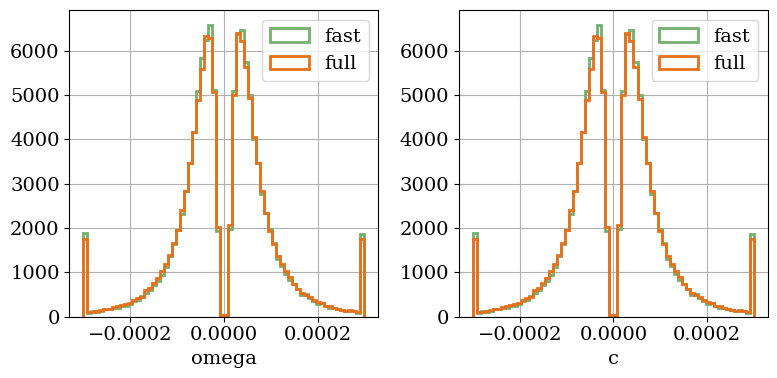

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
labels = [r"$d_0$ (mm)", r"$\phi$ (rad)", "$c$ (1/s)", "$z_0$ (mm)", r"$\tan{\lambda}$", r"$\omega$ (1/mm)", r"$C$ (1/mm)", r"$cot \theta$ (rad)"]
ranges = [(-0.05, 0.05), (-3.2, 3.2), (-0.1, 0.1), (-0.05, 0.05), (-5.0, 5.0), (-3e-4, 3e-4), (-0.01, 0.01), (-5.0, 5.0)] # (-4.5e-4, 4.5e-4)
r = [(-3e-4, 3e-4), (-3e-4, 3e-4)] #(-0.3, 0.3)
bins = 70
for i, k in enumerate(dic.keys()):
    if k == "full":
        d0, phi, c, z0, tanlam, omega, curv = get_5_track_params(dic[k], index_charged_3E_full)
    elif k == "fast":
        d0, phi, c, z0, tanlam, omega, curv = get_5_track_params(dic[k], index_charged_3E_fast)
    else:
        raise ValueError("Wrong key") 

    cSpeed = 2.99792458e8 * 10**(-9)
    #c = -1 *c*2*10**(-3)

    # overflow and underflow bins
    d0 = np.clip(d0, ranges[0][0], ranges[0][1])
    c = np.clip(c, r[i][0], r[i][1])
    z0 = np.clip(z0, ranges[3][0], ranges[3][1])
    tanlam = np.clip(tanlam, ranges[4][0], ranges[4][1])
    omega = np.clip(omega, ranges[5][0], ranges[5][1])
    curv = np.clip(curv, r_curv[k][0], r_curv[k][1])


    # plot only the curv of fast and full sim in two different plots 
    for j in range(2):
        axs[j].hist([omega, c][j], bins=bins, histtype='step', label=k, density=True, linewidth=2.0, range=r[j])
        axs[j].grid(True)
        axs[j].set_xlabel(["omega", "c"][j])
        axs[j].legend()
    


plt.tight_layout()
#plt.savefig("plots/Huu_5track_params.pdf")
plt.show()

ok we get $\omega = c = -c_{\mathrm{old}} \cdot 2 \cdot 10^{-3}$

Plot c and C

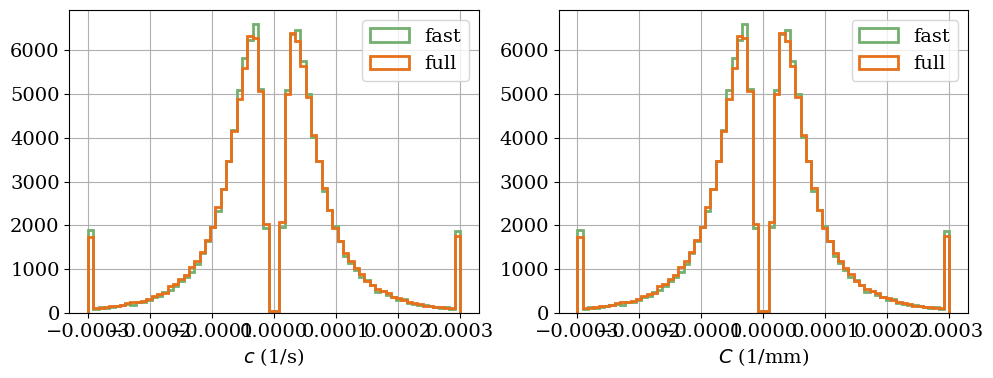

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
labels = ["$c$ (1/s)", r"$C$ (1/mm)"]
ranges = [(-0.3e-3, 0.3e-3), (-0.3e-3, 0.3e-3)] # (-4.5e-4, 4.5e-4) c old (-0.1, 0.1), curv old (-0.3, 0.3)
bins = 70
for k in dic.keys():
    if k == "full":
        d0, phi, c, z0, tanlam, omega, curv = get_5_track_params(dic[k], index_charged_3E_full)
        curv = curv *10**(-3)
        curv = curv *(-1)
    elif k == "fast":
        d0, phi, c, z0, tanlam, omega, curv = get_5_track_params(dic[k], index_charged_3E_fast)
        #curv = curv *10**(3)
    else:
        raise ValueError("Wrong key") 

    curv = curv *2

    # overflow and underflow bins

    c = np.clip(c, ranges[0][0], ranges[0][1])
    curv = np.clip(curv, ranges[1][0], ranges[1][1])


    # plot the 5 track parameters
    axs = axs.ravel()
    for i, ax in enumerate(axs):
        # plot the histograms
        if i == 8 or i == 7:
            continue
        ax.hist([c, curv][i], bins=bins, histtype='step', label=k, density=True, linewidth=2.0, range=ranges[i])
        ax.set_xlabel(labels[i])
        ax.legend()
        ax.grid(True)
plt.tight_layout()
#plt.savefig("plots/Huu_5track_params.pdf")
plt.show()


Find out width of $d_0$ and $z_0$:

[[7.10160446e-06 2.84584968e-03]
 [2.41439999e-05 2.96818151e-05]]
[[3.23060991e-05 3.42399751e-03]
 [3.40695657e-05 4.15274870e-05]]
[[-4.83965738e-07  5.88419965e-03]
 [ 5.62587368e-05  6.75667048e-05]]
[[-3.16845599e-05  3.13103552e-03]
 [ 6.61459098e-05  7.77986939e-05]]


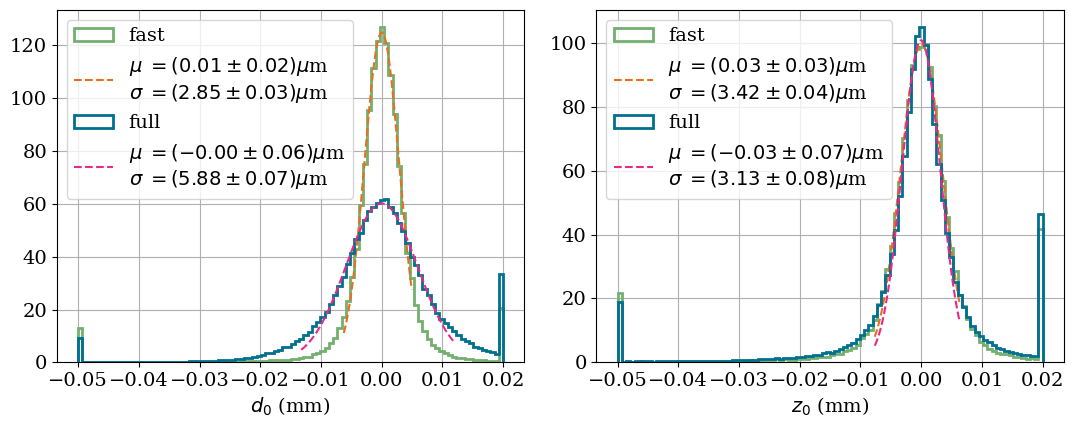

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(11, 4.5))
labels = [r"$d_0$ (mm)","$z_0$ (mm)"]
ranges = [(-0.05, 0.02), (-0.05, 0.020)]
bins = 100
for k in dic.keys():
    if k == "full":
        d0, phi, c, z0, tanlam, omega, curv = get_5_track_params(dic[k], index_charged_3E_full)
        curv = curv *10**(-3)
        curv = curv *(-1)
    elif k == "fast":
        d0, phi, c, z0, tanlam, omega, curv = get_5_track_params(dic[k], index_charged_3E_fast)
        #curv = curv *10**(3)
    else:
        raise ValueError("Wrong key") 

    curv = curv *2

    # overflow and underflow bins

    d0 = np.clip(d0, ranges[0][0], ranges[0][1])
    z0 = np.clip(z0, ranges[1][0], ranges[1][1])


    # plot the 5 track parameters
    axs = axs.ravel()
    for i, ax in enumerate(axs):
        # plot the histograms
        if i == 8 or i == 7:
            continue
        fits = plot_with_fit(ax, [d0, z0][i], bins, k, ranges[i])
        print(fits)
        #ax.hist([d0, z0][i], bins=bins, histtype='step', label=k, density=True, linewidth=2.0, range=ranges[i])
        ax.set_xlabel(labels[i])
        ax.legend(loc='upper left')
        ax.grid(True)
plt.tight_layout()
if save==True: 
    plt.savefig("plots/Huu_d0z0_gausfit.pdf")
plt.show()


In [57]:
def gaus_fit(containers, n_counts, label):
    # label should be '{L}' or '{NN}'
    x_centers = 0.5*(containers[:-1]+containers[1:])
    maxv = n_counts.max()
    ind_fit = np.where(n_counts[1:-2] > 0.15*maxv) # exclude the first and last bin because they are from the overflow
    liml = ind_fit[0].min()
    limu = ind_fit[0].max() + 1

    popt, pcov = curve_fit(gaus, x_centers[liml:limu], n_counts[liml:limu], p0=[0,1, 100], sigma=1/np.sqrt(n_counts)[liml:limu], maxfev=10000)
    perr = np.sqrt(np.diag(pcov))
    a1_fit = np.linspace(x_centers[liml:limu][0], x_centers[liml:limu][-1], 500)
    a2_fit = gaus(a1_fit, *popt)
    ax.plot(a1_fit, a2_fit, '--', label= r"$\mu_{} = ({:.2f} \pm {:.2f})\mu$m".format(label, popt[0]*10**3, perr[0]*10**3) + "\n" + r"$\sigma_{} = ({:.2f} \pm {:.2f})\mu$m".format(label, popt[1]*10**3, perr[1]*10**3))
    return popt, perr

def gaus(x, mu, sigma, A):
    return (A/np.sqrt(2*np.pi * sigma**2))* np.exp(-(x-mu)**2 / (2*sigma**2))

def plot_with_fit(ax, val, bins, k, r):
    fit_values = np.zeros(4) # mu, simga and then uncertainties

    n_counts, containers, patches = ax.hist(val, bins=bins, histtype='step', label=k, density=True, linewidth=2.0, range=r)
    popt, perr = gaus_fit(containers, n_counts, label='')
    fit_values = np.array([popt[0], popt[1], perr[0], perr[1]])

    return fit_values.reshape((2,2))

# Final 5 params plot:


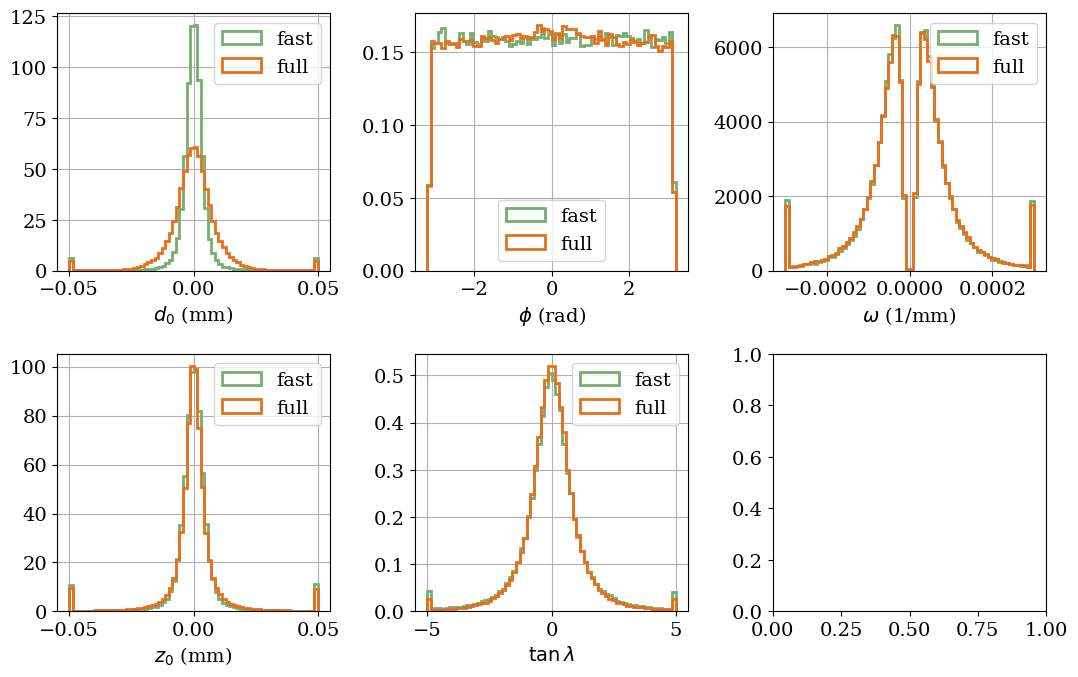

In [42]:
fig, axs = plt.subplots(2, 3, figsize=(11, 7))
labels = [r"$d_0$ (mm)", r"$\phi$ (rad)", r"$\omega$ (1/mm)", "$z_0$ (mm)", r"$\tan{\lambda}$"]
ranges = [(-0.05, 0.05), (-3.2, 3.2), (-3e-4, 3e-4), (-0.05, 0.05), (-5.0, 5.0)] # (-4.5e-4, 4.5e-4) c old (-0.1, 0.1), curv old (-0.3, 0.3)
bins = 70
for k in dic.keys():
    if k == "full":
        d0, phi, c, z0, tanlam, omega, curv = get_5_track_params(dic[k], index_charged_3E_full)
        curv = curv *10**(-3) * (-1) # so I do the same as in fast sim 
    elif k == "fast":
        d0, phi, c, z0, tanlam, omega, curv = get_5_track_params(dic[k], index_charged_3E_fast)
    else:
        raise ValueError("Wrong key") 

    curv = curv *2

    # overflow and underflow bins
    d0 = np.clip(d0, ranges[0][0], ranges[0][1])
    omega = np.clip(c, ranges[2][0], ranges[2][1])
    z0 = np.clip(z0, ranges[3][0], ranges[3][1])
    tanlam = np.clip(tanlam, ranges[4][0], ranges[4][1])


    # plot the 5 track parameters
    axs = axs.ravel()
    for i, ax in enumerate(axs):
        # plot the histograms
        if i == 5:
            continue
        ax.hist([d0, phi, omega, z0, tanlam][i], bins=bins, histtype='step', label=k, density=True, linewidth=2.0, range=ranges[i])
        ax.set_xlabel(labels[i])
        ax.legend()
        ax.grid(True)
plt.tight_layout()
if save==True: 
    plt.savefig("plots/Huu_5track_params.pdf")
plt.show()


Let's do 2D plots too! Maybe it's an issue with phi? We have 5 variables, so we get 4+3+2+1=10 plots. 

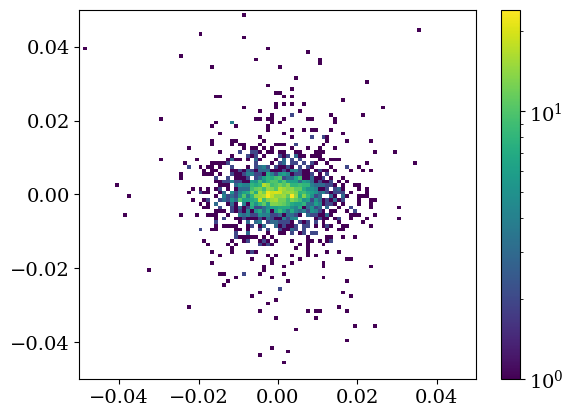

In [ ]:
ranges = {"pfcand_dxy": (-0.05, 0.05), 
        "pfcand_phi": (-3.2, 3.2),
        "pfcand_c": (-0.1, 0.1), 
        "pfcand_dz": (-0.05, 0.05), 
        "pfcand_tanlam": (-5.0, 5.0)}
d0, phi, c, z0, tanlam = get_5_track_params(dic["full"], index_charged_3E_full, )
plt.hist2d(d0, z0, norm=LogNorm(), cmap='viridis', bins=100, range=[ranges["pfcand_dxy"], ranges["pfcand_dz"]])
plt.colorbar()
plt.show()

In [35]:

def trackparams5_2dplots(key, index):

    # Define parameter ranges
    ranges = {
        "pfcand_dxy": (-0.03, 0.03),
        "pfcand_phi": (-3.2, 3.2),
        "pfcand_omega": (-3e-4, 3e-4),
        "pfcand_c": (-0.1, 0.1),
        "pfcand_dz": (-0.04, 0.04),
        "pfcand_tanlam": (-5.0, 5.0)
    }

    d0, phi, c, z0, tanlam, omega_, _ = get_5_track_params(dic[key], index)

    # Map parameters to their names and ranges
    params = {
        "d0": (d0, ranges["pfcand_dxy"]),
        "phi": (phi, ranges["pfcand_phi"]),
        "omega": (c, ranges["pfcand_omega"]),
        "z0": (z0, ranges["pfcand_dz"]),
        "tanlam": (tanlam, ranges["pfcand_tanlam"])
    }

    # Parameter names
    param_names = list(params.keys())
    labels = [r"$d_0$ (mm)", r"$\phi$ (rad)", r"$\omega$ (1/mm)", "$z_0$ (mm)", r"$\tan{\lambda}$"] 

    # Create figure for the 10 plots
    fig, axes = plt.subplots(2, 5, figsize=(18, 8), constrained_layout=True)
    axes = axes.flatten()

    # Counter for subplot index
    plot_idx = 0

    # Iterate over all combinations of parameters (i < j)
    for i in range(len(param_names)):
        for j in range(i + 1, len(param_names)):
            ax = axes[plot_idx]
            
            # Get parameter data and ranges
            x_data, x_range = params[param_names[j]]
            y_data, y_range = params[param_names[i]]
            
            # Create 2D histogram
            hist = ax.hist2d(x_data, y_data, bins=100, norm=LogNorm(), cmap='viridis', range=[x_range, y_range])
            ax.grid(True)
            
            # Set labels
            ax.set_xlabel(labels[j])
            ax.set_ylabel(labels[i])
            
            plot_idx += 1

    if save==True: 
        plt.savefig(f"plots/Huu_{key}_5trackparams_2d.pdf")

    plt.show()


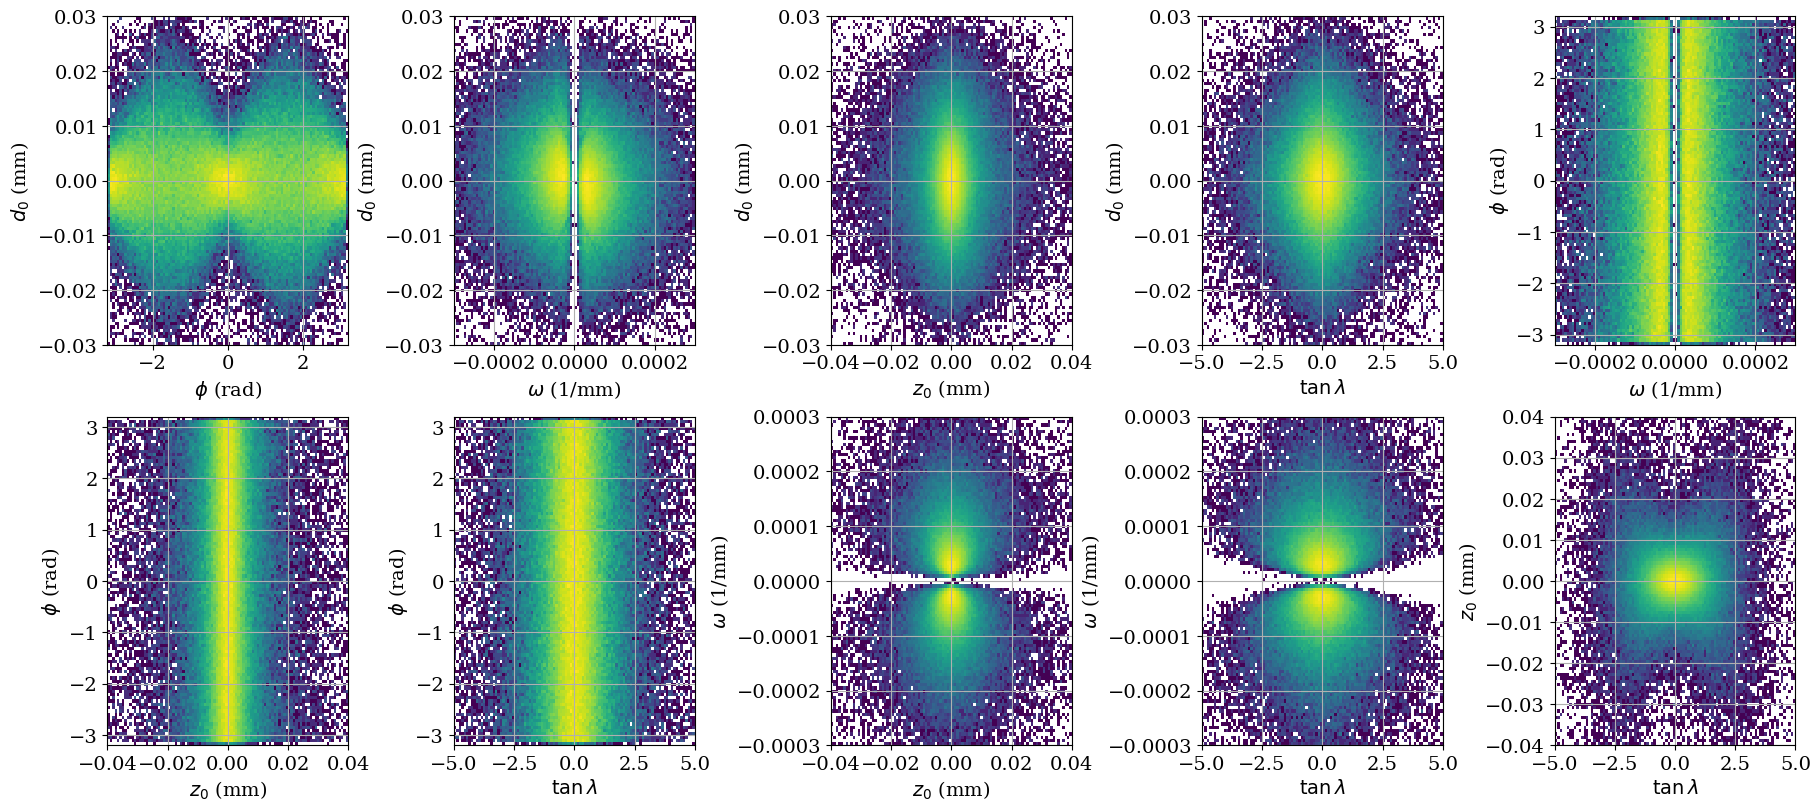

In [43]:
trackparams5_2dplots("full", index_charged_3E_full)

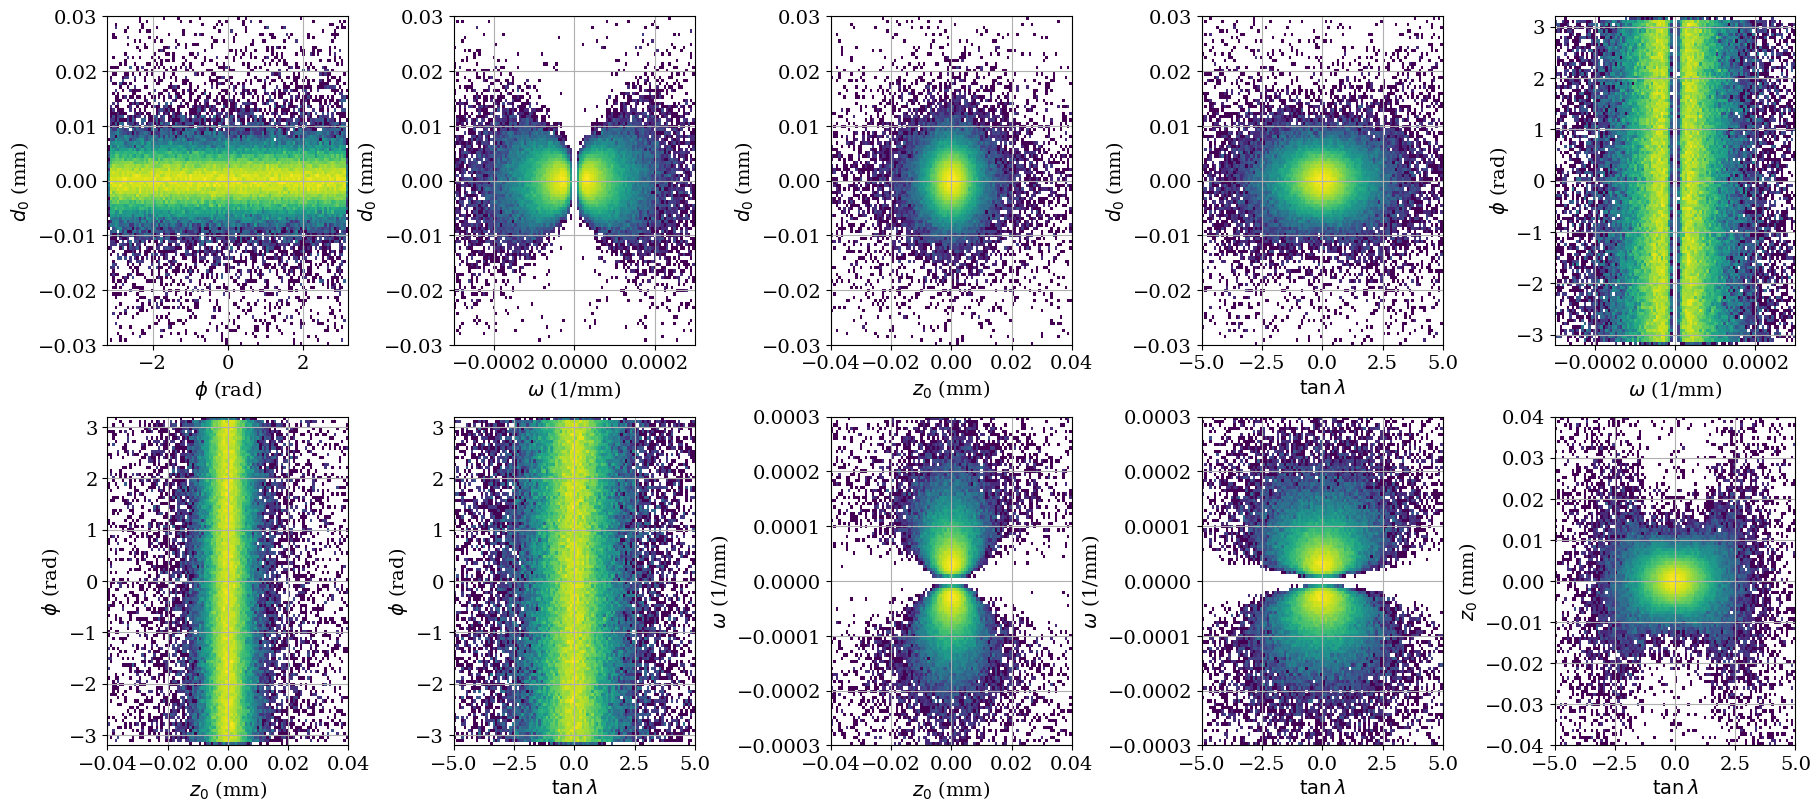

In [44]:
trackparams5_2dplots("fast", index_charged_3E_fast)

## Covariance parameters

Now let's have a look at the cov matrix elements. As I just retrieve them straight forward from fast and full sim, it is important to understand what these refer to _exactely_. 

**Full sim**: 
- [Here](https://github.com/key4hep/EDM4hep/blob/997ab32b886899253c9bc61adea9a21b57bc5a21/edm4hep.yaml#L195C9-L200) is the documentation. 
- They use the same track parameters as I do, apart from $c$ as they use $\omega$ instead. While $c$ has units of $1/s$, $\omega$ has $1/mm$. 

**Fast sim**: 
This will get tidious, as I need to dig really deep to find this out. 
- [Here](https://github.com/HEP-FCC/FCCAnalyses/blob/pre-edm4hep1/addons/ONNXRuntime/python/jetFlavourHelper.py#L131), the variables are retrieved from C++ to python. 
- [Here](https://github.com/HEP-FCC/FCCAnalyses/blob/pre-edm4hep1/analyzers/dataframe/src/JetConstituentsUtils.cc#L303) is the C++ definition. 
- [Here](https://github.com/HEP-FCC/FCCAnalyses/blob/pre-edm4hep1/analyzers/dataframe/src/ReconstructedParticle2Track.cc#L415) is the cov Matrix accessed. 
- [Here](https://github.com/key4hep/k4SimDelphes/blob/main/converter/src/DelphesEDM4HepConverter.cc#L573) is the covMatrix definied using a conversion from code from FB. 

Now it get's interesting. Here we see the definition of $\omega$ using $c$: 

```
// relating to curvature (index 2)
double scale2 = -2.;  // CAREFUL: DELPHES USES THE HALF-CURVATURE
trackState.omega = cand->C * scale2;
```

But this at least means, that everything in fast sim should be the same as in full sim / key4hep! Also the file is called DelphesEDM4HepConverter.cc which is promissing. 
- Because we see [here](https://github.com/key4hep/k4SimDelphes/blob/main/converter/src/DelphesEDM4HepConverter.cc#L539-L562) that **the same helix parametrization** is used!!
- Again, [here](https://github.com/delphes/delphes/blob/master/modules/TrackCovariance.cc#L173) we see the same definition of track params. 
- [Here](https://github.com/delphes/delphes/blob/2f87c5edc29159cb335ea2cda77b70dca5d94c50/external/TrackCovariance/TrkUtil.cc#L304-L316), we see the conversion that is used... e.g. from omega to c: it seems to be a factor of -2 plus units. 


*Discrepencies in cov*: 

- cov(c, d0): values differ a bit
- cov(c,  phi): values differ a bit
- cov(c, tanlam): sign: fast only >0
- cov(c, z0): sign, fast only <0
- cov(phi, tanlam): sign, fast only>0
- cov(phi, z0): sing, fast only<0
- cov(d0, tanlam): sign, fast only < 0
- cov(d0, z0): sign, fast only>0

What can we **conclude**? 

- I am confused about cov(d0, z0) - why is this in fast sim only positive and not symmetric around 0? As d0 and z0 are symmetric around 0?


In [45]:
keys = [
'pfcand_dxydxy',
'pfcand_dphidxy',
'pfcand_dxyc',
'pfcand_dptdpt',
'pfcand_dlambdadz',
'pfcand_phic',
'pfcand_dphidphi',
'pfcand_phictgtheta',
'pfcand_phidz',
'pfcand_dzdz',
'pfcand_dxydz',
'pfcand_cdz',
'pfcand_detadeta',
'pfcand_dxyctgtheta',
'pfcand_cctgtheta',]

xlabels = {
    'pfcand_cctgtheta': r"cov($c$, $\tan{\lambda}$)",
    'pfcand_cdz': r"cov($c$, $z_0$)",
    'pfcand_detadeta': r"cov($\tan{\lambda}$, $\tan{\lambda}$)",
    'pfcand_dlambdadz': r"cov($\tan{\lambda}$, $z_0$)",
    'pfcand_phic': r"cov($\phi$, $c$)",
    'pfcand_phictgtheta': r"cov($\phi$, $\tan{\lambda}$)",
    'pfcand_phidz': r"cov($\phi$, $z_0$)",
    'pfcand_dphidphi': r"cov($\phi$, $\phi$)",
    'pfcand_dphidxy': r"cov($\phi$, $d_0$)",
    'pfcand_dptdpt': r"cov($c$, $c$)",
    'pfcand_dxyc': r"cov($d_0$, $c$)",
    'pfcand_dxyctgtheta': r"cov($d_0$, $\tan{\lambda}$)",
    'pfcand_dxydxy': r"cov($d_0$, $d_0$)",
    'pfcand_dxydz': r"cov($d_0$, $z_0$)",
    'pfcand_dzdz': r"cov($z_0$, $z_0$)",
}

r = {
    'pfcand_cctgtheta': [-1e-11, 1e-11],
    'pfcand_cdz': [-2e-10, 2e-10],
    'pfcand_detadeta': [0, 0.5e-6],
    'pfcand_dlambdadz': [-0.5e-5, 0],
    'pfcand_phic': [0, 0.2e-10],
    'pfcand_phictgtheta': [-0.2e-08, 0.2e-08], 
    'pfcand_phidz': [-0.05e-6, 0.05e-6],
    'pfcand_dphidphi': [0.0, 0.3e-6], 
    'pfcand_dphidxy': [-0.3e-5, 0],
    'pfcand_dptdpt': [0, 5e-13], #[0, 0.5e-13], 
    'pfcand_dxyc': [-0.25e-9, 0.25e-9],
    'pfcand_dxyctgtheta': [-0.1e-6, 0.1e-6], 
    'pfcand_dxydxy': [0, 8e-5],
    'pfcand_dxydz': [-0.25e-5, 0.25e-5], # here
    'pfcand_dzdz': [0, 9e-5],
}

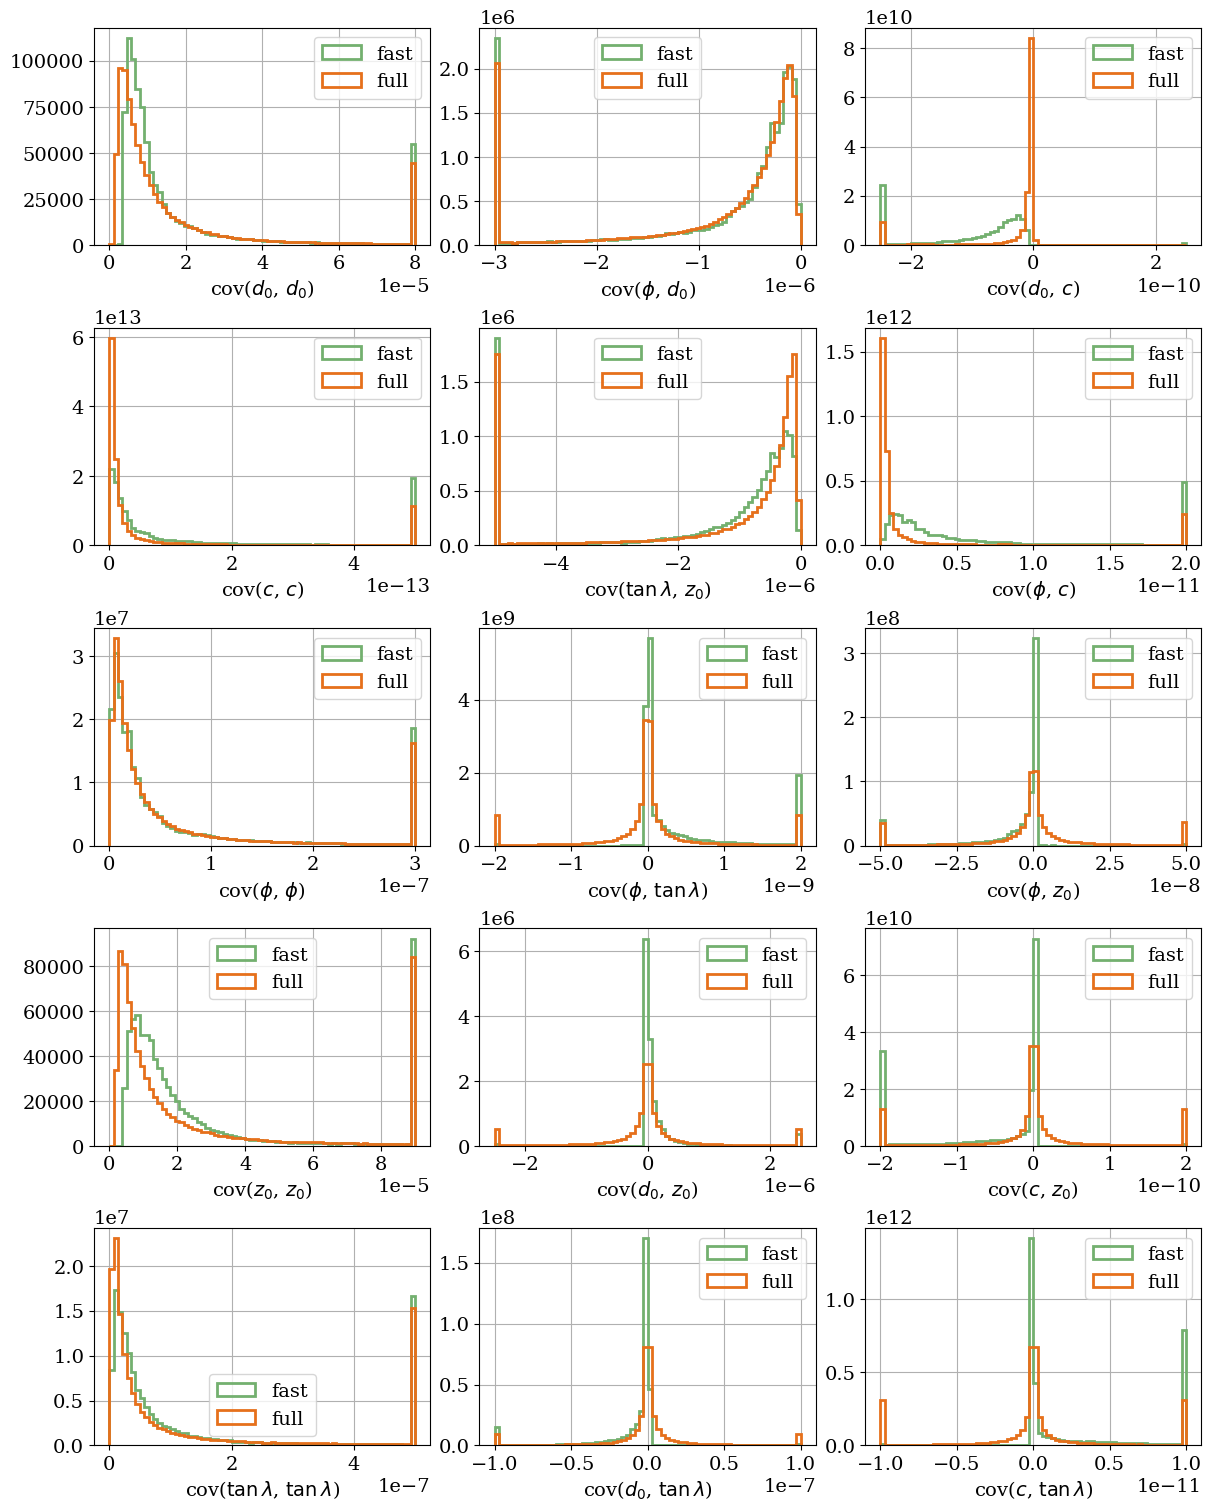

In [46]:
fig, axs = plt.subplots(5, 3, figsize=(12, 15), constrained_layout=True)
bins = 70
for k in dic.keys():
    for i, key in enumerate(keys):
        if k == "full":
            d = get_chad_elements(dic[k][key], index_charged_3E_full)[0]
        elif k == "fast":
             d = get_chad_elements(dic[k][key], index_charged_3E_fast)[0]
        else:
            raise ValueError("Wrong key") 
        d = np.clip(d, r[key][0], r[key][1])
        ax = axs.ravel()
        ax[i].hist(d, bins=bins, histtype='step', label=k, density=True, linewidth=2.0, range=r[key])
        ax[i].set_xlabel(xlabels[key])
        ax[i].legend()
        ax[i].grid(True)
#plt.tight_layout()
#plt.savefig("plots/Huu_15covmat_params.pdf")
plt.show()